# iLykei Lecture Series

# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Project:  Generative Models

## Notebook: Variational Autoencoders


## Yuri Balasanov, Mihail Tselishchev, &copy; iLykei 2019

##### Main texts: 

**Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurelien Geron, &copy; Aurelien Geron 2017, O'Reilly Media, Inc**

**[Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114), 2013, Diederik P Kingma, Max Welling, arXiv:1312.6114 [stat.ML]**    

**[Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908), 2016, Carl Doersch, arXiv:1606.05908 [stat.ML]**


# Variational Autoencoders

In this section we build various deep autoencoders and train them on *MNIST* dataset.

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

# Introduction

In this section we construct Variational Autoencoder (VAE) for *MNIST* dataset. Variational autoencoders differ significantly from autoencoders described in previous notebooks. See [this article](https://arxiv.org/abs/1606.05908) for more comprehensive theory.

First, variational autoencoders are **probabilistic** autoencoders. This means that for any feature vector $x$ encoder outputs a **distribution on the latent coding space**  rather than just a point $z$.

Second, variational encoders are **generative**. This means that one can generate new data instances in hierarchical way:

1. Generate *latent* coding $z \sim P_Z$;
2. Generate datapoint $x \sim P_{X|Z=z}$ for selected $z$.

Note that taking random coding and decoding it using common decoder may not produce a representative datapoint $x$. In contrast, variational autoencoders *are designed in a way to produce representative objects*.


For MNIST dataset latent variable $z$ may contain some useful encoded information, like number, stroke width and the angle at which the number is written. However, the purpose of variational encoder is not  interpretation of latent variable values, but rather generating new latent variables.
That is why $P_Z$ is typically taken to be $\mathcal{N}(0, I)$ (where $I$ is the identity matrix).
Since any multidimensional distribution can be obtained from gaussian distribution using some functional transformation (almost like any one-dimensional distribution can be obtained from uniform distribution), this choice is not restrictive.

For scaled MNIST dataset (each pixel value is normalized to be between zero and one) posterior distribution of reconstructions $P_{X|Z=z}$ is selected as binomial $\text{Bern}(f_\theta(z))$, with probability of success parameter $f_\theta$ representing the *decoder function* with trainable parameters $\theta$.

To encode the input datapoint $x$ it is necessary to find conditional distribution $P_{Z|X=x}$. That can be done using Bayes' rule and MCMC, but the result would be rather complicated because denominator of Bayes rule is not computationally tractable. Instead, $P_{Z|X=x}$ is approximated with some simple distribution $Q_{Z|X=x}$, typically $Q_{Z|X=x} = \mathcal{N}(\mu_\phi(x), \Sigma_\phi(x))$, where $\Sigma_\phi(x) = \text{diag}(\sigma_1^2(x), \ldots, \sigma_k^2(x))$ and $\phi$ is a vector of trainable parameters.

[Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) is used as a distance between approximation $Q_{Z|X=x}$ and original distribution $P_{Z|X=x}$:
$$
KL(Q \| P) = \mathbb{E}_Q \ln \frac{q(Z)}{p(Z)} = \int \ln \frac{q(z)}{p(z)} \cdot q(z) \, dz,
$$
where $q$ and $p$ are corresponding probability density functions.

In our case, applying Bayes' rule to $p(z|x)$, gives
$$
KL(Q_{Z|X=x} \| P_{Z|X=x}) 
= \int \ln \frac{q(z|x)}{p(z|x)} \cdot q(z|x) \, dz
\\= KL(Q_{Z|X=x} \| P_{Z}) + \ln p(x) - \int \ln p(x|z) \cdot q(z|x) \, dz
\\= KL(Q_{Z|X=x} \| P_{Z}) + \ln p(x) - \mathbb{E}_{Q_{Z|X=x}} \ln p(x|Z).
$$
In other words,
$$
\ln p(x)  - KL(Q_{Z|X=x} \| P_{Z|X=x}) 
=  \mathbb{E}_{Q_{Z|X=x}} \ln p(x|Z) - KL(Q_{Z|X=x} \| P_{Z}).
$$
Taking an expectation over training data $D$,
$$
\mathbb{E}_{X\sim D} \ln p(X) - \mathbb{E}_{X\sim D}  KL(Q_{Z|X} \| P_{Z|X}) 
=  \mathbb{E}_{X\sim D} \Bigl( \mathbb{E}_{Q_{Z|X}}  \ln p(X|Z) -  KL(Q_{Z|X} \| P_{Z}) \Bigr).
$$
Note that in machine learning we usually want to maximize the log-likelihood $\mathbb{E}_{X\sim D} \ln p(X)$ over trainable variables $\theta$ and $\phi$. However, in the latter equation the second term in the left-hand side is difficult to calculate because of complicated $P_{Z|X}$. 
So we are going to maximize not $\mathbb{E}_{X\sim D} \ln p(X)$, but rather a right-hand side of the last equation. Since Kullback–Leibler divergence is non-negative, we're *maximizing the variational lower bound of log-likelihood function* using minibatch stochastic gradient ascend.

In fact terms on the right-hand side are very handy. Since all measures are gaussian with specified covariates, one can check that second term is a differentiable function of *encoder parameters* $\phi$:
$$
KL(Q_{Z|X=x} \| P_{Z}) = \frac12 \sum_{j=1}^k (\mu_j^2 (x) + \sigma_j^2(x) - \ln \sigma_j^2(x) - 1),
$$
where $k$ is dimension of $z$, and all $\mu_j(x)$ and $\sigma^2_j(x)$ depend on $\phi$.

The first term on the right-hand side $\mathbb{E}_{X\sim D} \mathbb{E}_{Q_{Z|X}} \ln p(X|Z)$ can be estimated via sampling $x$ from training data, $z$ from $Q_{Z|X=x}$, calculating $\ln p(x|z)$ and averaging over samples. However, this operation is non-differentiable over $\phi$, so it is not possible to use error backpropagation algorithm directly. Instead, use reparametrization trick:
$$
\mathbb{E}_{Q_{Z|X=x}} \ln p(x|Z) = 
\mathbb{E}_{\varepsilon\sim \mathcal{N}(0,1)} \ln p(x|Z=\mu_\phi(x) + \Sigma_\phi^{1/2} \varepsilon)
$$
and resulting function is differentiable on both *encoder parameters* $\phi$ and *decoder parameters* $\theta$.
Recall that $P_{X|Z=z}$ is a Bernoulli distribution with mean $f_\theta(z)$ for MNIST problem, so 
$$\ln p(x|Z=z) = x \ln f_\theta(z) + (1-x) \ln (1-f_\theta(z)).$$

Using the theory, construct variational autoencoder. 

First, load MNIST dataset.

In [40]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [41]:
import numpy as np
from keras.layers import Dense, Input, Flatten, Reshape, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
from keras.utils import plot_model

Make a function that builds variational autoencoder using keras model functional API.
This function also returns VAE loss, which is minus $\mathbb{E}_{X\sim D} \Bigl( \mathbb{E}_{Q_{Z|X}}  \ln p(X|Z) -  KL(Q_{Z|X} \| P_{Z}) \Bigr)$. The first term is known as `reconstruction loss`, while the second is known as `latent loss`.

Note that we use $\gamma = \ln(\sigma^2)$ instead of $\sigma$ since $\gamma$ is not bounded (moreover, it helps to speed up convergence). In order to generate $\varepsilon$ in Keras, use corresponding Lambda layer with custom `sampling` function.

# Main function

Create a function that puts together all components of variational autoencoder. Make the code universal, so that it can produce a conventional autoencoder with similar general structure if we need.

- Create all necessary tensors:

    1. Encoder:
        - Input layer with `input_shape` units
        - Hidden tensor with `n_hidden1` units
        - Hidden tensor with `n_hidden2` units
        - Complete the encoder part either with dense layer of `n_hidden3` units (regular autoencoder) or  with a `Lambda` layer that simulates sample from `n_hidden3`-dimensional Gaussian distribution (variational autoencoder). Latent space dimension is `n_hidden3`.
    
    2. Decoder: 
        - Input layer with `n_hidden3` units
        - Hidden layer with `n_hidden4` units
        - Hidden layer with `n_hidden5` units
        - Output layer with `input_shape` units
    
- Create encoder, decoder and autoencoder models

- Define reconstruction, latent and total loss functions 

- Return encoder, decoder, combined autoencoder and 3 types of loss

In [42]:
def create_vae(input_shape, 
               n_hidden1, n_hidden2, 
               n_hidden3, # latent dim
               n_hidden4, n_hidden5,
               is_vae=True,
               binary_input=False
              ):
    # tensors:
    input_encoder = Input(shape=input_shape)
    x = Flatten()(input_encoder) if len(input_shape) > 1 else input_encoder
    x = Dense(n_hidden1, activation='elu')(x)
    x = Dense(n_hidden2, activation='elu')(x)

    def sampling(args):
        z_mu, z_gamma = args
        epsilon = K.random_normal(shape=K.shape(z_mu))
        return z_mu + K.exp(z_gamma/2) * epsilon
    
    if is_vae:
        z_mu = Dense(n_hidden3, activation=None)(x)
        # using gamma=ln(sigma^2) instead of sigma
        z_gamma = Dense(n_hidden3, activation=None)(x)  
        z = Lambda(sampling, output_shape=(n_hidden3,))([z_mu, z_gamma])
    else:
        z = Dense(n_hidden3, activation='elu')(x)
    
    input_decoder = Input(shape=(n_hidden3,))
    x = Dense(n_hidden4, activation='elu')(input_decoder)
    x = Dense(n_hidden5, activation='elu')(x)
    outputs_flattened = Dense(np.prod(input_shape), 
                              activation='sigmoid' if binary_input else None)(x)
    outputs = Reshape(input_shape)(outputs_flattened)

    # models:
    m_encoder = Model(input_encoder, z, name='encoder') 
    m_decoder = Model(input_decoder, outputs, name='decoder')
    m_ae = Model(input_encoder, m_decoder(m_encoder(input_encoder)), name='ae')
    
    # losses:
    def reconstruct_loss(x_original, x_restored):
        # sum squared errors over all axes but the first (minibatch) one
        return 0.5 * K.sum(K.square(x_original- x_restored), 
                           axis=np.arange(1, len(K.int_shape(x_original))))
    
    def reconstruct_loss_binary(x_original, x_restored):
        # sum binary crossentropies over all axes but the first (minibatch) one
        return K.sum(K.binary_crossentropy(x_original, x_restored), 
                     axis=np.arange(1, len(K.int_shape(x_original))))
    
    if binary_input: # True for MNIST example; False for Rates example
        reconstruct_loss = reconstruct_loss_binary
    
    def latent_loss(x_original, x_restored):
        return 0.5 * K.sum(K.square(z_mu) + K.exp(z_gamma) - z_gamma - 1, axis=-1)
    
    def vae_loss(x_original, x_restored):
        return reconstruct_loss(x_original, x_restored) + latent_loss(x_original, x_restored)
    
    if not is_vae:
        latent_loss = None
        vae_loss = None

    return m_encoder, m_decoder, m_ae, reconstruct_loss, latent_loss, vae_loss

# Defining variational autoencoder: MNIST

In [43]:
input_shape = X_train.shape[1:]
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 2  # latent dimension
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1

In [44]:
vae_encoder, vae_decoder, vae, reconstruct_loss, latent_loss, vae_loss = create_vae(input_shape, 
                                                                            n_hidden1, n_hidden2, 
                                                                            n_hidden3, 
                                                                            n_hidden4, n_hidden5,
                                                                            is_vae=True,
                                                                            binary_input=True)
plot_model(vae_encoder, to_file='vae_encoder.png',show_shapes=True,show_layer_names=True)
plot_model(vae_decoder, to_file='vae_decoder.png',show_shapes=True,show_layer_names=True)
plot_model(vae, to_file='vae_complete.png',show_shapes=True,show_layer_names=True)

vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 2)                 645004    
_________________________________________________________________
decoder (Model)              (None, 28, 28)            644784    
Total params: 1,289,788
Trainable params: 1,289,788
Non-trainable params: 0
_________________________________________________________________


Architecture of variational autoencoder
![Vae plot](vae_complete.png)

In [45]:
vae_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 784)          0           input_7[0][0]                    
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 500)          392500      flatten_3[0][0]                  
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 500)          250500      dense_21[0][0]                   
__________________________________________________________________________________________________
dense_23 (

Architecture of the encoder:
![Encoder plot](vae_encoder.png)

In [46]:
vae_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 500)               1500      
_________________________________________________________________
dense_26 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_27 (Dense)             (None, 784)               392784    
_________________________________________________________________
reshape_4 (Reshape)          (None, 28, 28)            0         
Total params: 644,784
Trainable params: 644,784
Non-trainable params: 0
_________________________________________________________________


Architecture of the decoder:
![Decoder plot](./vae_decoder.png)

Compile autoencoder with `vae_loss` as loss function. Also measure reconstrucion and latent losses to make sure everything is fine.

In [47]:
learning_rate = 0.001
vae.compile(optimizer=Adam(learning_rate), loss=vae_loss, 
            metrics=[reconstruct_loss, latent_loss])

# Fitting variational autoencoder: MNIST

Fit autoencoder:

In [48]:
n_epochs = 50
batch_size = 150

vae.fit(X_train, X_train,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 21s 353us/step - loss: 191.4421 - reconstruct_loss_binary: 185.9032 - latent_loss: 5.5389 - val_loss: 172.9178 - val_reconstruct_loss_binary: 168.1171 - val_latent_loss: 4.8006
Epoch 2/50
60000/60000 [==============================] - 23s 379us/step - loss: 169.1369 - reconstruct_loss_binary: 164.3528 - latent_loss: 4.7841 - val_loss: 166.5192 - val_reconstruct_loss_binary: 161.6446 - val_latent_loss: 4.8745
Epoch 3/50
60000/60000 [==============================] - 22s 362us/step - loss: 164.1950 - reconstruct_loss_binary: 159.1818 - latent_loss: 5.0131 - val_loss: 162.3414 - val_reconstruct_loss_binary: 157.3513 - val_latent_loss: 4.9900
Epoch 4/50
60000/60000 [==============================] - 16s 266us/step - loss: 160.7905 - reconstruct_loss_binary: 155.5626 - latent_loss: 5.2279 - val_loss: 159.7026 - val_reconstruct_loss_binary: 154.4420 - val_latent_loss: 5.2606
Epoch 5/50

60000/60000 [==============================] - 15s 255us/step - loss: 143.1560 - reconstruct_loss_binary: 136.6917 - latent_loss: 6.4643 - val_loss: 144.6834 - val_reconstruct_loss_binary: 138.1782 - val_latent_loss: 6.5052
Epoch 36/50
60000/60000 [==============================] - 16s 259us/step - loss: 142.8228 - reconstruct_loss_binary: 136.3560 - latent_loss: 6.4668 - val_loss: 144.4031 - val_reconstruct_loss_binary: 137.9638 - val_latent_loss: 6.4393
Epoch 37/50
60000/60000 [==============================] - 16s 262us/step - loss: 142.8509 - reconstruct_loss_binary: 136.3838 - latent_loss: 6.4671 - val_loss: 144.1366 - val_reconstruct_loss_binary: 137.7486 - val_latent_loss: 6.3881
Epoch 38/50
60000/60000 [==============================] - 16s 275us/step - loss: 142.8119 - reconstruct_loss_binary: 136.3225 - latent_loss: 6.4895 - val_loss: 143.8818 - val_reconstruct_loss_binary: 137.5579 - val_latent_loss: 6.3238
Epoch 39/50
60000/60000 [==============================] - 17s 281us

# Analysis of variational autoencoder: MNIST

Plot some decodings from `X_test`. Note that since encoder is probabilistic, outputs are random.

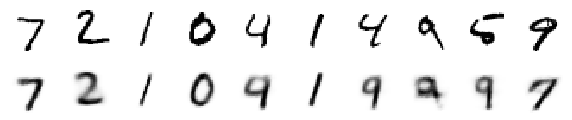

In [49]:
n_test_digits = 10

imgs = X_test[:n_test_digits]
reconstructed_imgs = vae.predict(imgs)


def plot_imgs(*args, n_imgs=None):
    n_rows = len(args)
    if n_imgs is None:
        n_imgs = args[0].shape[0]
    fig = plt.figure(figsize=(n_imgs, n_rows))
    for row in range(n_rows):
        for col in range(n_imgs):
            plt.subplot(n_rows, n_imgs, row * n_imgs + col + 1)
            plt.imshow(args[row][col], cmap='Greys', interpolation='nearest')
            plt.axis('off')


plot_imgs(imgs, reconstructed_imgs)

Results are not perfect because latent dimension was only 2. However, this choice allows making 2d visualizations of latent variables for all data (colored along y-labels):

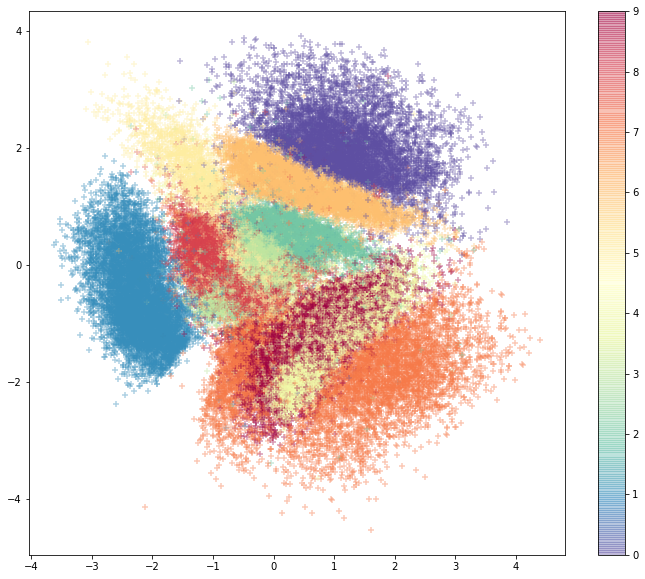

In [50]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])
X_encoded = vae_encoder.predict(X)

plt.figure(figsize=(12, 10))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], 
            c=y, cmap=plt.cm.Spectral_r, alpha=0.4, marker='+')
plt.colorbar()

Note that latent codings for some classes significantly overlap.

# Generating samples using variational autoencoder: MNIST

Since the model is generative, it can generate *new* digits by sampling from latent distribution and using decoder: create a grid in the latent space, then simulate an image decoding each of the grid values.

## Grid in the encoding space

Select a grid in the encodings space as on the plot above. Predict observations for each value on the grid using decoder.

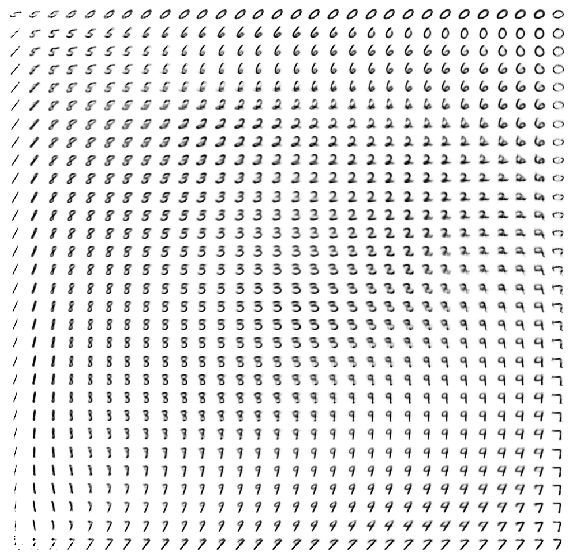

In [51]:
import scipy.stats

n = 30
quantiles = scipy.stats.norm.ppf(np.linspace(0.001, 0.999, n))

plt.figure(figsize=(10, 10))
for (row, z2) in enumerate(reversed(quantiles)):
    for (col, z1) in enumerate(quantiles):
        z = np.array([[z1, z2]])
        x_decoded = vae_decoder.predict(z)
        plt.subplot(n, n, row * n + col + 1)
        plt.imshow(x_decoded[0], cmap='Greys', interpolation='nearest')
        plt.axis('off')

## Simulated versions of the same input

Now select one input image and plot first its codings, then predict using these codings and the decoder. 

In [85]:
[y_train[9]]

[4]

In [86]:
first_image_20 = [X_train[9]]*20
first_image_20 = np.array(first_image_20, dtype='float')
X_encoded = vae_encoder.predict(first_image_20)
X_encoded

array([[ 0.21909109, -2.237494  ],
       [ 0.30148673, -2.0989451 ],
       [ 0.36373976, -2.1839366 ],
       [ 0.40783802, -2.1562963 ],
       [ 0.40040898, -2.12278   ],
       [ 0.259195  , -2.0871947 ],
       [ 0.30645004, -2.0719795 ],
       [ 0.32815576, -2.0333648 ],
       [ 0.36813232, -2.0826037 ],
       [ 0.3586326 , -2.1544573 ],
       [ 0.236538  , -2.136109  ],
       [ 0.33760843, -2.140173  ],
       [ 0.45962575, -2.1108208 ],
       [ 0.31982708, -2.1589484 ],
       [ 0.35416   , -2.1907592 ],
       [ 0.36459434, -2.1225746 ],
       [ 0.38243964, -1.9307079 ],
       [ 0.41816485, -2.1166198 ],
       [ 0.33465996, -2.1715858 ],
       [ 0.32827652, -2.129875  ]], dtype=float32)

Plot encodings

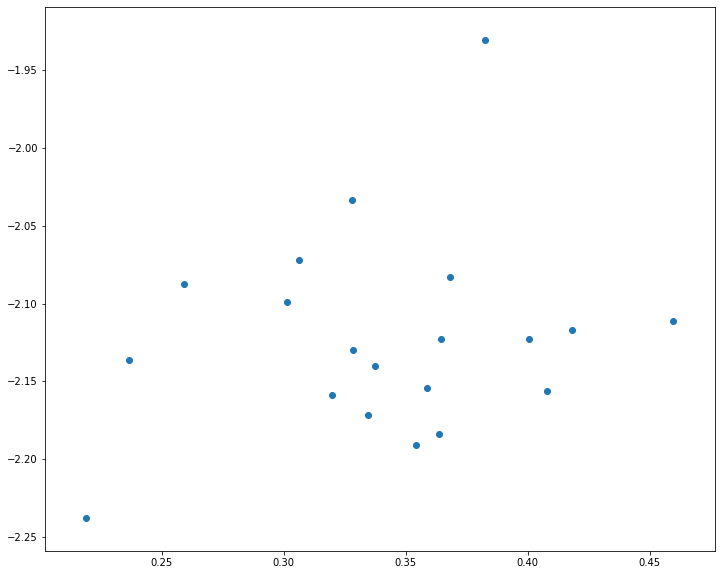

In [87]:
plt.figure(figsize=(12, 10))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1])

Simulate one image per each encoding using decoder.

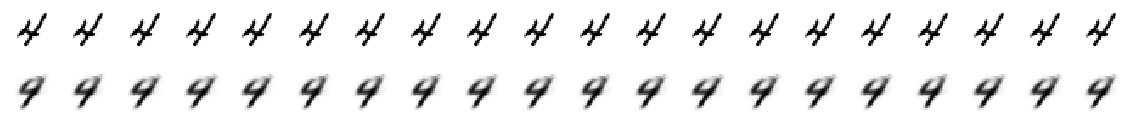

In [88]:
X_simulated = vae_decoder.predict(X_encoded)
plot_imgs(first_image_20,X_simulated)

# Regular autoencoder: MNIST

Compare distribution of variational autoencoder encodings with the distribution predicted by a regular autoencoder.

The description of the network below is almost the same as in the previous section, but the lines of code related to creating latent distribution and Kullback-Leibler divergence measure to the usual logloss are not used.

In [89]:
encoder, decoder, ae, reconstruct_loss, latent_loss, ae_loss = create_vae(input_shape,n_hidden1, 
                                                                            n_hidden2,n_hidden3,
                                                                            n_hidden4, n_hidden5,
                                                                            is_vae=False,
                                                                            binary_input=True)
plot_model(encoder, to_file='encoder.png',show_shapes=True,show_layer_names=True)
plot_model(decoder, to_file='decoder.png',show_shapes=True,show_layer_names=True)
plot_model(ae, to_file='ae.png',show_shapes=True,show_layer_names=True)

ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 2)                 644002    
_________________________________________________________________
decoder (Model)              (None, 28, 28)            644784    
Total params: 1,288,786
Trainable params: 1,288,786
Non-trainable params: 0
_________________________________________________________________


Regular stacked autoencoder:
![Reg Autoencoder plot](ae.png)

Encoder of regular stacked autoencoder:
![Reg Encoder plot](encoder.png)

Decoder of regular stacked autoencoder:
![Decoder plot](decoder.png)

Compile and train the autoencoder.

In [90]:
learning_rate = 0.001
ae.compile(optimizer=Adam(learning_rate), loss=reconstruct_loss, 
            metrics=[reconstruct_loss])

In [91]:
n_epochs = 50
batch_size = 150

ae.fit(X_train, X_train,
       epochs=n_epochs,
       batch_size=batch_size,
       validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 17s 288us/step - loss: 182.8046 - reconstruct_loss_binary: 182.8046 - val_loss: 163.1527 - val_reconstruct_loss_binary: 163.1527
Epoch 2/50
60000/60000 [==============================] - 14s 241us/step - loss: 159.0467 - reconstruct_loss_binary: 159.0467 - val_loss: 154.2728 - val_reconstruct_loss_binary: 154.2728
Epoch 3/50
60000/60000 [==============================] - 14s 233us/step - loss: 152.4982 - reconstruct_loss_binary: 152.4982 - val_loss: 150.3298 - val_reconstruct_loss_binary: 150.3298
Epoch 4/50
60000/60000 [==============================] - 14s 236us/step - loss: 148.4112 - reconstruct_loss_binary: 148.4112 - val_loss: 146.1523 - val_reconstruct_loss_binary: 146.1523
Epoch 5/50
60000/60000 [==============================] - 14s 239us/step - loss: 145.5981 - reconstruct_loss_binary: 145.5981 - val_loss: 144.3127 - val_reconstruct_loss_binary: 144.3127
Epoch 6/50
6000

60000/60000 [==============================] - 13s 222us/step - loss: 129.2375 - reconstruct_loss_binary: 129.2375 - val_loss: 132.9034 - val_reconstruct_loss_binary: 132.9034
Epoch 45/50
60000/60000 [==============================] - 13s 221us/step - loss: 129.1617 - reconstruct_loss_binary: 129.1617 - val_loss: 133.4354 - val_reconstruct_loss_binary: 133.4354
Epoch 46/50
60000/60000 [==============================] - 15s 245us/step - loss: 128.8861 - reconstruct_loss_binary: 128.8861 - val_loss: 133.6791 - val_reconstruct_loss_binary: 133.6791
Epoch 47/50
60000/60000 [==============================] - 13s 221us/step - loss: 129.0326 - reconstruct_loss_binary: 129.0326 - val_loss: 133.1443 - val_reconstruct_loss_binary: 133.1443
Epoch 48/50
60000/60000 [==============================] - 14s 234us/step - loss: 128.7329 - reconstruct_loss_binary: 128.7329 - val_loss: 132.9956 - val_reconstruct_loss_binary: 132.9956
Epoch 49/50
60000/60000 [==============================] - 14s 241us/ste

Show some results of reconstruction.

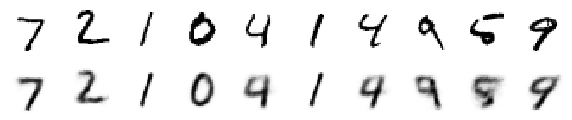

In [92]:
n_test_digits = 10

imgs = X_test[:n_test_digits]
reconstructed_imgs = ae.predict(imgs)


def plot_imgs(*args, n_imgs=None):
    n_rows = len(args)
    if n_imgs is None:
        n_imgs = args[0].shape[0]
    fig = plt.figure(figsize=(n_imgs, n_rows))
    for row in range(n_rows):
        for col in range(n_imgs):
            plt.subplot(n_rows, n_imgs, row * n_imgs + col + 1)
            plt.imshow(args[row][col], cmap='Greys', interpolation='nearest')
            plt.axis('off')


plot_imgs(imgs, reconstructed_imgs)

Plot latent space. 

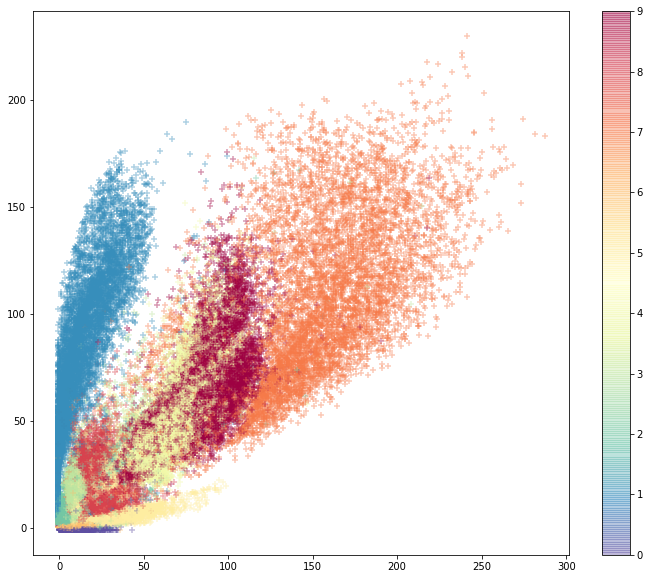

In [93]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])
X_encoded = encoder.predict(X)

plt.figure(figsize=(12, 10))
plt.scatter(X_encoded[:, 1], X_encoded[:, 0], 
            c=y, cmap=plt.cm.Spectral_r, alpha=0.4, marker='+')
plt.colorbar()

As expected, encodings of the regular stacked autoencoder cluster much more and do not represent a distribution.

## Variational Autoencoder for Risk Management

Recall US bonds rates data. We are going to use VAE to model plausible risk scenarios for the purposes of risk management.

In [94]:
import numpy as np
import pandas as pd

RatesData = pd.read_csv("RegressionAssignmentData2014.csv", index_col="Date").iloc[:,:7]
RatesData.head()

,USGG3M,USGG6M,USGG2YR,USGG3YR,USGG5YR,USGG10YR,USGG30YR
Date,,,,,,,
1/5/1981,13.52,13.09,12.289,12.28,12.294,12.152,11.672
1/6/1981,13.58,13.16,12.429,12.31,12.214,12.112,11.672
1/7/1981,14.50,13.90,12.929,12.78,12.614,12.382,11.892
1/8/1981,14.76,14.00,13.099,12.95,12.684,12.352,11.912
1/9/1981,15.20,14.30,13.539,13.28,12.884,12.572,12.132


Plot the data.

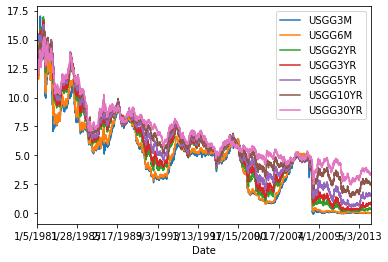

In [95]:
RatesData.plot()

Create train & validation data sets:

In [96]:
data_arr = RatesData.values
train_sz = int(0.8 * RatesData.shape[0])
X_train, X_test = np.vsplit(data_arr[np.random.permutation(data_arr.shape[0])], [train_sz])
print('X_train.shape=', X_train.shape)
print(' X_test.shape=', X_test.shape)

X_train.shape= (6640, 7)
 X_test.shape= (1660, 7)


Use the same VAE structure as before, but with `squared error` instead of `binary crossentropy` as reconstruction loss (and, consequently, with no activation on output layer).

In [97]:
input_shape = X_train.shape[1:]
n_hidden1 = 4
n_hidden2 = 4
n_hidden3 = 2  # latent dimension
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1

rvae_encoder, rvae_decoder, rvae, \
rvae_reconstruct_loss, rvae_latent_loss, \
rvae_loss = create_vae(input_shape, 
                        n_hidden1, n_hidden2, 
                        n_hidden3, # latent dim
                        n_hidden4, n_hidden5, is_vae=True, binary_input=False)
rvae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 7)                 0         
_________________________________________________________________
encoder (Model)              (None, 2)                 72        
_________________________________________________________________
decoder (Model)              (None, 7)                 67        
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________


In [98]:
plot_model(rvae_encoder, to_file='rvae_encoder.png',show_shapes=True,show_layer_names=True)
plot_model(rvae_decoder, to_file='rvae_decoder.png',show_shapes=True,show_layer_names=True)
plot_model(rvae, to_file='rvae_complete.png',show_shapes=True,show_layer_names=True)

Architecture of the encoder:
![rvaeEncoder plot](./rvae_encoder.png)

Architecture of the decoder:
![rvaeDecoder plot](./rvae_decoder.png)

Architecture of the variational autoencoder:
![rvaeAutoencoder plot](./rvae_complete.png)

Adjust optimizer and fit VAE.

In [99]:
learning_rate = 0.001
rvae.compile(optimizer=Adam(learning_rate), loss=rvae_loss, 
            metrics=[rvae_reconstruct_loss, rvae_latent_loss])

n_epochs = 100
batch_size = 150

rvae.fit(X_train, X_train,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_data=(X_test, X_test))

Train on 6640 samples, validate on 1660 samples
Epoch 1/100
6640/6640 [==============================] - 2s 374us/step - loss: 136.1363 - reconstruct_loss: 130.5059 - latent_loss: 5.6303 - val_loss: 120.5826 - val_reconstruct_loss: 110.4119 - val_latent_loss: 10.1707
Epoch 2/100
6640/6640 [==============================] - 0s 22us/step - loss: 104.9325 - reconstruct_loss: 90.3755 - latent_loss: 14.5570 - val_loss: 87.2022 - val_reconstruct_loss: 69.2750 - val_latent_loss: 17.9271
Epoch 3/100
6640/6640 [==============================] - 0s 21us/step - loss: 74.0891 - reconstruct_loss: 56.1808 - latent_loss: 17.9083 - val_loss: 61.2809 - val_reconstruct_loss: 44.2405 - val_latent_loss: 17.0404
Epoch 4/100
6640/6640 [==============================] - 0s 22us/step - loss: 52.1972 - reconstruct_loss: 35.7997 - latent_loss: 16.3975 - val_loss: 43.3856 - val_reconstruct_loss: 28.7166 - val_latent_loss: 14.6690
Epoch 5/100
6640/6640 [==============================] - 0s 23us/step - loss: 36.98

6640/6640 [==============================] - 0s 21us/step - loss: 5.1085 - reconstruct_loss: 1.7030 - latent_loss: 3.4055 - val_loss: 5.1139 - val_reconstruct_loss: 1.6698 - val_latent_loss: 3.4440
Epoch 40/100
6640/6640 [==============================] - 0s 17us/step - loss: 5.0550 - reconstruct_loss: 1.6785 - latent_loss: 3.3764 - val_loss: 5.0710 - val_reconstruct_loss: 1.6407 - val_latent_loss: 3.4304
Epoch 41/100
6640/6640 [==============================] - 0s 17us/step - loss: 5.0162 - reconstruct_loss: 1.6677 - latent_loss: 3.3485 - val_loss: 5.1321 - val_reconstruct_loss: 1.6488 - val_latent_loss: 3.4833
Epoch 42/100
6640/6640 [==============================] - 0s 16us/step - loss: 5.0345 - reconstruct_loss: 1.6661 - latent_loss: 3.3684 - val_loss: 5.0194 - val_reconstruct_loss: 1.7054 - val_latent_loss: 3.3140
Epoch 43/100
6640/6640 [==============================] - 0s 17us/step - loss: 4.9434 - reconstruct_loss: 1.6255 - latent_loss: 3.3178 - val_loss: 4.9320 - val_reconstru

Epoch 78/100
6640/6640 [==============================] - 0s 23us/step - loss: 3.5954 - reconstruct_loss: 1.2877 - latent_loss: 2.3077 - val_loss: 3.5971 - val_reconstruct_loss: 1.2569 - val_latent_loss: 2.3402
Epoch 79/100
6640/6640 [==============================] - 0s 19us/step - loss: 3.5829 - reconstruct_loss: 1.2860 - latent_loss: 2.2969 - val_loss: 3.5732 - val_reconstruct_loss: 1.2576 - val_latent_loss: 2.3156
Epoch 80/100
6640/6640 [==============================] - 0s 18us/step - loss: 3.5730 - reconstruct_loss: 1.2899 - latent_loss: 2.2831 - val_loss: 3.6227 - val_reconstruct_loss: 1.2902 - val_latent_loss: 2.3325
Epoch 81/100
6640/6640 [==============================] - 0s 18us/step - loss: 3.5721 - reconstruct_loss: 1.2724 - latent_loss: 2.2998 - val_loss: 3.5901 - val_reconstruct_loss: 1.2863 - val_latent_loss: 2.3037
Epoch 82/100
6640/6640 [==============================] - 0s 18us/step - loss: 3.5671 - reconstruct_loss: 1.2580 - latent_loss: 2.3091 - val_loss: 3.5940 - 

Now visualize latent variables. color code shows time as number of days of observation.

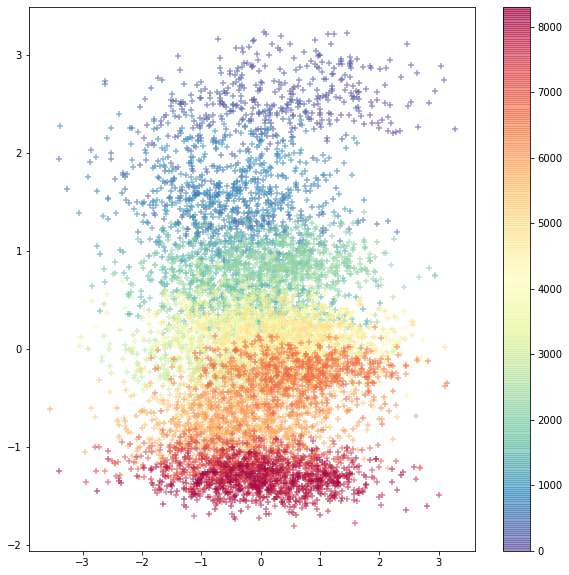

In [100]:
X_encoded = rvae_encoder.predict(RatesData.values)

plt.figure(figsize=(10, 10))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], marker='+',
           c=range(RatesData.values.shape[0]), cmap=plt.cm.Spectral_r, alpha=0.6)
plt.colorbar()

Now, for the purpose of risk management, we may need to generate plausible term curves conditional on the current curve.
Using variational autoencoder generate latent variables using multivariate gaussian distribution with zero means and identity covariance matrix. Decode them to obtain rate curves.

In [101]:
n = 40
z = np.random.normal(loc=0.0, scale=1.0, size=(n, 2))
print("Latent coding: ",z)

Latent coding:  [[ 0.46821909  0.0808561 ]
 [-0.43210669  2.22426648]
 [-1.23575308 -1.42506448]
 [ 0.04415185  3.01586782]
 [ 2.62090509  0.88634661]
 [ 2.67438608  0.1189745 ]
 [ 0.47305104  1.17674878]
 [ 1.8688083  -1.1581748 ]
 [-0.73696337  1.42621402]
 [-1.80416982  1.15466648]
 [ 2.6463386   0.94414193]
 [-0.43747531  0.99901006]
 [ 1.52483474  0.2628021 ]
 [ 2.51211596  0.34326439]
 [-0.52031362 -1.20753702]
 [-0.70294684  0.70049776]
 [ 0.62714692 -0.18660257]
 [-1.434818    0.84247072]
 [ 0.73811078  1.38938248]
 [-2.88557154 -0.35120242]
 [-1.0533242   0.96250672]
 [ 0.18368136  0.33270072]
 [ 0.98291014  0.29534626]
 [-0.81710712  0.66150381]
 [-1.48663911  0.79306195]
 [ 0.07963057 -0.50697117]
 [-0.51605025  0.21672617]
 [-0.79215122 -1.6139507 ]
 [-0.84710077 -0.59340563]
 [ 0.65501211 -2.09962134]
 [ 1.16427018  0.48225507]
 [ 1.33765327  1.83864264]
 [-1.79520811 -0.73569443]
 [ 1.7117891  -1.2554284 ]
 [ 0.93265113  0.40711728]
 [-0.55468265 -0.73271449]
 [-0.2108204

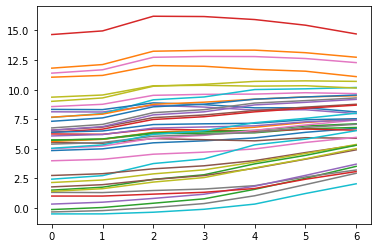

In [102]:
x_decoded = rvae_decoder.predict(z)

for i in range(n):
    plt.plot(x_decoded[i,])

These scenarios have extremely high range because simulation is done from the entire latent space and the period since 1981.

Instead, condition generation of the term curves by today's curve (latest observation).

In [104]:
RatesData.iloc[-1:]

,USGG3M,USGG6M,USGG2YR,USGG3YR,USGG5YR,USGG10YR,USGG30YR
Date,,,,,,,
6/26/2014,0.0253,0.0507,0.4646,0.8803,1.6462,2.5214,3.3458


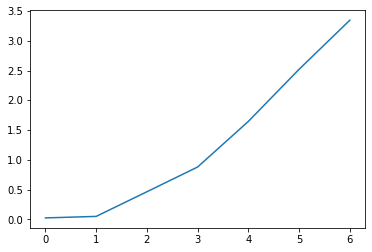

In [105]:
x = RatesData.iloc[-1:].values
plt.plot(x[0])

Encode it multiple times to get sample from $Q_{Z|X=x}$.

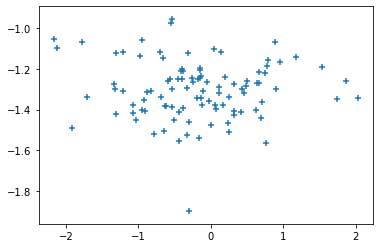

In [106]:
n = 100
z = rvae_encoder.predict(np.vstack([x for _ in range(n)]))
plt.scatter(z[:,0], z[:,1], marker='+')

Now generate scenario curves from a more reasonable range.

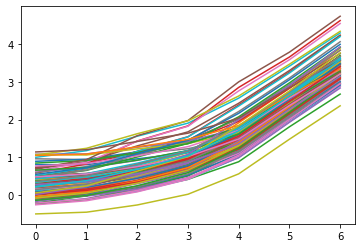

In [107]:
x_decoded = rvae_decoder.predict(z)

for i in range(n):
    plt.plot(x_decoded[i,])